In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import graph_util, graph_io

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
from lucid.optvis import objectives, param, render, transform
import matplotlib.pyplot as plt



512 1326.65


<img src="data:image/PNG;base64,iVBORw0KGgoAAAANSUhEUgAAAIAAAACACAIAAABMXPacAACjF0lEQVR4nAThZcy1DWIg5t3MfJjPeRje52X6mIc8Y1h77XW8u3I2XSlNq6iR8qNq/7Rqf0Vqm6qrJKvuNrGzZPZ4xuP5Bj6Gl/lhOMw3M9+9LvDpn/9//o//5uOBBSUljkSRaw3od77/3v/w3//PGl4oX26v142ShIR+ZD3znuhTwDeiWWx6ASixaznUnSvoh1dKcvL0777mr3JNtLTzx/8n+MUnv3z0/Df/d/+V96tf/+T5q9qmf/zliNjeQOGlcWos+zFRFuA4DfoyzqDrv3N78Knu2sG6xPyX/+f68cEhHoLx0nFiKN1o4ZUf9J/I8YsH2tmJbWdYkRfqRaVYKWcXxRpEtUU3gYQkSBzUPnODwTxUbbhacIpvOGIegOn5T36Vwuz6d+/8w1/9GbB91Ti+wIV2nh2+XfTr79z4n//V30t5cPt67bO/OKPrVwvS/PSVwYi1jVZ869bG4emUK11KrKiF6Lqh8jERs3madinrEeqotgWeCZfod/5ZPH7knz2hjTFgG8L2KnvzLdAKstPPA0/WMS6gxSl13ZueJ88O53bEXG3cvtWEexO1G+WTVd84//aWDb7/9gfztOZCKZC5b31w+906+nisfPH1fr1au/O7b+J+DzFs10HuffxzzzNikqnXpc0rdcMDB70gDgapn1BN2tcDMqEuvf1hneW7Z0vNkLdbpXtPXp52T0LQB2hQgGJ55lBMzIqSs0DS2KWACMqzSSxsXH5reNYzjp7gHfGffq8wn08dC6ve+MfaLPfsP/z5Uh3qKVbY3hZQwRm+iCmguFNtNKoFOpQzFUOgZLm4/+tRnWI8qNq8UsI5AcZwOab6BypszNEcsFRDd65QN+92T45i2WQFpCSBrkNFELvFQbnLG6OToxwSliR8juans4X6qgeBHFkmG3ms2NoO48y1XMB8lQw1EpiRtMUmAFxvwOu/eaSJa3v84S9+ER48X9lcq1zbFRBoePYNjulJkY4a752Fq+rjx8aLb+HYFJvF1DMrrYp2uMBjNl8uVmvViaMgRC1fsGeGjWZ5obs8c9QwkHUcgztXmp46xY0TmBVNeZ5BSBCTrFgvVcqnzyalG1feuIuM9bI5Xfi+q6e+uzR6R8/3fuN39rsDM7Bj8ZJuDgJMJ8ukAOI1ttDcxhZjB6egnRtFDPT7vRnLUqApdF+e+ixDrLUh1Tw4URG6BLbef/go+vTf/T8hAKbotdW9Td/ZH8hnkRkiBgBYcySkbIZKqGYaqN0jlau3GF7aa7YLLHZw1k+K1O5aedbXj7sKqiu1Ri21gHIy09zQCpd8bjsFEwwnLjU7lyX5XveojiLvrot/9eQiJJEr7eKIaipugJgKAsZUvrzdaAzUSRNALCON5cniyWcIg+hpw9UiKjAhUMBy/MFMk2pOXpuYqMcwQsbwmitCNkG588lwEaJkgjgrkh9psEiAhSKmDI1pP9QHvYmVIu9fXz2c2QtVsX0rM8xJhsRB2Lhcw5gATbyYLTNQMDuXZS1tNKpOEB0MJ401iU0VmNpxTnqaZQV60FiVXN+odDYRAM4UuVCqTxfHRqhoy4CisfVL7eV4afjBUvEQxTh90s1CoFjGHBRYu7y2Ikn97jwEcxAVyHNMFm77hxfdbz5BYL5SulnJJQj6cPtSYe7VLRO7eHq0VDT+QG3c2l46gCq7nfV36bzYauQIz5RHx3m6BMBUbAROv0fgaOwjy4GCMkUs4audLBgv82LcbO+dHc1Rxjt0lkUKqmaIFqHvXivvT41IjqdTmqUDzzgNmM5KObevhoh8MU4cixQ6Vy+hFMXGznSYFCVBjyIismpr9U99Z+xnv3d99+GTzzAkxhKxUCxalAAatqHJpqPVmmynhsR4lGqJp0Mgn6tiVCIWa0UYAVKqmuPa+Y7hDp5Pl9r5UKzyFBkY9hIM6HLOtNToyeESopja629++5OfoXEEeYCWxNev4Qs5b/mZhZmy7YE4Qvr6ZNKNyWLoJ0wij3o2IaKXdy8pLsQX1hzlDKcNZ2lXyqxQb+BJNDlT9z9/Ud1q7ZRKz170U77igly0/7W1UPMsVd97XaJDgh0JWWE0kzBKp1BiZ0t8+sKYKRPwZJ+trYmiFKUBzVJLx461RWIT7mKcSfgevsY26vLpmVgoCLkczKyP+882tullxGWgeHpwJmEw63sAS/QNtMTh3aVboMxWq3awwOxwUa9lkAHXd7cQqUxlOh4SpgMWQGCmsX7trmWfIZ5hKxdYfXs4PpHWOiFK9rUZnKNPFvrm5lZD6jzRlE0+ffRld7wY80V2YxdFXCiNSZKu0qus0KqkQtGNZDIVkMPDwa3L1+am32xc7dQNY33j4cmZ0XXzrNG4Rdkh/OLRS4jkShsbAgMZ8pKB0JiCIjtyM57lpNg7kypi4BHtnSLB8nCM4EgEgMaDoycgmTUbdKQFIFM29GGqLqyFz5e5UmV9pXkVDuO12uLv/vpb+d4BJ5mVdtVUycHoAAw1KbfuiyUQ3G/ReYl/faScXIyPvBApdxo8x69slMbnfWV2vLK9M1iMi3UCg6PR4VM4zSbjSaFUF9iCk6K3rxQifeYwLIMyNGjp/vLJt6PNTnOTAI9dz0UDJAhjXGKgtITDluFGARV6xV5viKRRuFTnPrJT3IkykAj7p70DC2AygQKTCBTrAA4zax3YPvd8TcJzFOSLTSFy3L4StzsttljoOmaDx5M4uRgOksBobtU2cJ9FSkYqjm0EIPmDk4tQeUHgjDHtIa9dvzSY+FJJ8OejKI7Lrdx3mCtGkPVHysWrhazb53MUkQrrjerg7Exq5N3Ef/VqeWujGhhHPuyUiyXdshko9LyCZtOJMZ6ruuy8VCZGqYJCEeiABUafJ7Bxofkkz1y7+s5u6448QzzERbnK7/+B9Lc/f2wHobZYwJjIoJkfUTZIRspid7U6y+AHn/w5jwlvvvb60djrnY+jZo6TBHS89KPo2f6TVqeFB0XfYmMEptJs640PCkIRChGeiLIAQel8PFwG2GIRmTkW48pFnarfHw7vvL3+6uRMJaSlrENjGchXbm7k44R+LvvRcnx3jXl1tsxtfH+nUwz9ceaqIEQbsiXzMZdG6DJxIdGFbCaFQySxE8A8H+arlLmgP/760dt3bxqjA0AQ2Xz73qm+ODlgc+I11irShZfDkhkwqm0g4xc4g5dKFZqAueYdaEkxYDB05QUaLpEEXZ4beFpqSc03r9fIjDWXuAdJG9dfDwKfgTChzMZe4PVkPXTOjVlIcTCSpaCfq5cudZqYAMqR4yR9fWFhLIlABETQdtpVwlH3eBq6QL21ubvyo8UMjTKXJsCEKAj1y7evXsETIHRjZThIMZZhiFn/xRWuCJFwt/dibyNnblz/+HAYaccN3tYHI9li6u2OE7jWtK9aWRJok7Nnl658kKYSC5TVhW0vTs+fPPSx3OVbW53dRkBhdKVuJmR58ybDRmCgPPjqxTq/hY8TXkTau9UMBH92oA7mmABnDOhMTd0jC83djRj3FPnA9XrH41MolWPbFfnypd3a7o12py3l8lQVc0EWM0yottZhitTFi3PDm1ZzjACTISx9+819BE6bRXB9vbzQSwjDAEDcqJG3Pnzt7Y++d/nK+sraCksgyKJ3RmYq4NsJm0djO2X4oS1Dp5oLmYAfNPO56pWbgaHDaNmIyHKHm5+P/RD1/NhQppCfxCKw2tmjCWFmGr3jJ72LoblwQRZu1Npp6EBAMD+eZF5MQkB5tXhz4y0gAQHURqK5mOGZaSLNldrlO+OpMz7p0kiSRXoQ0hvS2ifHT66wO7+9e+MEoxbPDuoEKhBIDHI6UnHMkxTGy+VNXR+OD7/C1t7c23xDd1IIsSfDfZ6m6BJqGuTZswcAkY57p43m2sL1HZAZvDwmIbVZatpwtpxr21VuiUESFFi51Fiwsm/T
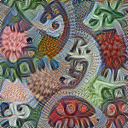

In [30]:
### Sanity check for lucid_tests install
model = models.InceptionV1()
model.load_graphdef()

# rendered
_ = render.render_vis(model, 'mixed4a_pre_relu:476')

# plt.imshow(rendered)



### Import custom model


Needs to import TF-trained model _graph definition_ and _checkpoint_ files

#### If importing a keras model:

In [31]:
# Load keras model
base_folder = '/Users/ricardobarroslourenco/PycharmProjects/clouds_rdcep/experimental/m19/'
with open((base_folder+'ae.json'), 'r') as file:
    k_model = tf.keras.models.model_from_json(file.read())
k_model.load_weights(base_folder+'ae.h5')

In [32]:
# Convert keras model object to a TF model object
num_output = 1 # Number of outputs (Default = 1). 
pred = [None]*num_output
pred_node_names = [None]*num_output

for i in range(num_output):
    pred_node_names[i] = 'output_node'+str(i)
    pred[i] = tf.identity(k_model.outputs[i], name=pred_node_names[i])

print("Output node names are: ", pred_node_names)

sess = tf.keras.backend.get_session()
tf.train.write_graph(sess.graph.as_graph_def(), base_folder, 'ae.tf_graphdef' , as_text=True)
print('Saved graph definition in ascii format at: '+base_folder+'ae.tf_graphdef')

Output node names are:  ['output_node0']


Saved graph definition in ascii format at: /Users/ricardobarroslourenco/PycharmProjects/clouds_rdcep/experimental/m19/ae.tf_graphdef


In [33]:
# Export weights
constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
graph_io.write_graph(constant_graph, base_folder, 'ae.tf_weights')
print('Saved TF graph at: '+base_folder+'ae.tf_weights')

INFO:tensorflow:Froze 12 variables.


INFO:tensorflow:Froze 12 variables.


Converted 12 variables to const ops.
Saved TF graph at: /Users/ricardobarroslourenco/PycharmProjects/clouds_rdcep/experimental/m19/ae.tf_weights


### Load trained model to Lucid